## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load model

In [21]:
from tensorflow.keras.models import model_from_json

model_filepath = "./saved_models/resnet50.json"
weights_filepath = "./saved_models/resnet_ckpt4_epoch_16_val_loss_0.606.weights.h5"

json_file = open(model_filepath, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(weights_filepath)
print("Loaded model from disk")

Loaded model from disk


In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,539,531 (169.90 MB)

 Trainable params: 6,983,939 (26.64 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 13,967,880 (53.28 MB)

## Load dataset

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '../chest-xray-pneumonia/Data_blance/Train'
test_dir = '../chest-xray-pneumonia/Data_blance/Test'
val_dir = '../chest-xray-pneumonia/Data_blance/Val'

img_size = 224
batch_size = 32
channels = 3   # 3 channels for color images

train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    zca_whitening = False,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.2,
    zoom_range = 0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
)

test_set = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

val_set = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

Found 3900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 279 images belonging to 3 classes.


## Continue training

In [5]:
# Get last evaluation result
scores_val = model.evaluate(val_set)
print("Val Loss:", scores_val[0])
print("Val Accuracy:", scores_val[1])

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8243 - loss: 0.4767 - precision: 0.8361 - recall: 0.7884
Val Loss: 0.607803225517273
Val Accuracy: 0.7025089859962463


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

os.makedirs('saved_models', exist_ok=True)
checkpoint_filepath = "saved_models/resnet_ckpt4_epoch_{epoch:02d}_val_loss_{val_loss:.3f}.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True
)

checkpoint_callback.best = scores_val[0]  # Set best loss to previous known value

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)

In [7]:
hist = model.fit(
  x=train_set, 
  epochs=30, 
  validation_data=val_set,
  callbacks=[checkpoint_callback, early_stopping_callback]
  # class_weight=class_weights_dict,
)

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6532 - loss: 0.7099 - precision: 0.6841 - recall: 0.5915
Epoch 1: val_loss did not improve from 0.60780
122/122 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.6533 - loss: 0.7099 - precision: 0.6842 - recall: 0.5916 - val_accuracy: 0.6810 - val_loss: 0.6207 - val_precision: 0.7103 - val_recall: 0.6416
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6732 - loss: 0.6871 - precision: 0.7079 - recall: 0.6259
Epoch 2: val_loss did not improve from 0.60780
122/122 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.6732 - loss: 0.6871 - precision: 0.7079 - recall: 0.6260 - val_accuracy: 0.6989 - val_loss: 0.6119 - val_precision: 0.7203 - val_recall: 0.6738
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6853 - loss: 0.6740 - precision: 0.7075 - recall: 0.6258
Epoch 3: val_loss did not improve from 0.60780
122/122 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.6852 - loss: 0.6740 - precision: 0.70

## Plot Loss & Accuracy

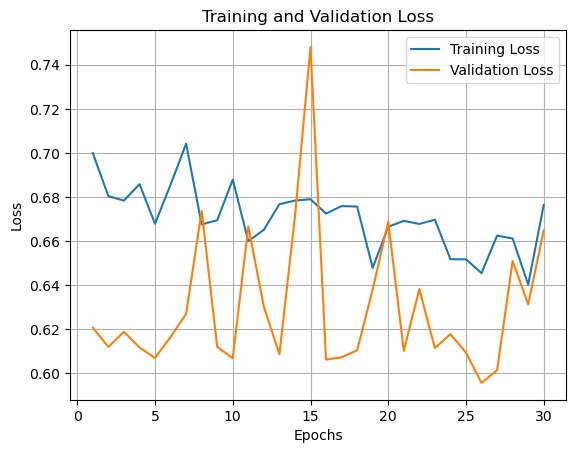

In [8]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

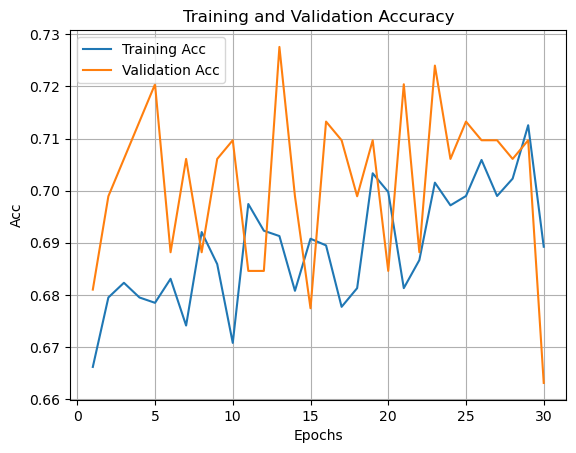

In [9]:
# Extract the training and validation accuracy values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the accuracy graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
scores_train = model.evaluate(train_set)

122/122 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7134 - loss: 0.6263 - precision: 0.7370 - recall: 0.6670


In [11]:
scores_test = model.evaluate(test_set)

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8261 - loss: 0.4368 - precision: 0.8616 - recall: 0.8013


In [12]:
scores_val = model.evaluate(val_set)

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8381 - loss: 0.4281 - precision: 0.8579 - recall: 0.8095


In [13]:
# Print evaluation scores
print("Train Loss:", scores_train[0])
print("Train Accuracy:", scores_train[1])
print("Test Loss:", scores_test[0])
print("Test Accuracy:", scores_test[1])
print("Validation Loss:", scores_val[0])
print("Validation Accuracy:", scores_val[1])

Train Loss: 0.6325740218162537
Train Accuracy: 0.7146154046058655
Test Loss: 0.5831267237663269
Test Accuracy: 0.7099999785423279
Validation Loss: 0.5955660343170166
Validation Accuracy: 0.7096773982048035


In [22]:
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_set.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


### Result from weights_filepath = "./saved_models/resnet_ckpt4_epoch_16_val_loss_0.606.weights.h5"

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true, y_pred, target_names=val_set.class_indices)
print(report)

              precision    recall  f1-score   support

      Normal       0.89      0.90      0.90       100
    bacteria       0.64      0.58      0.61       100
       virus       0.55      0.59      0.57       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



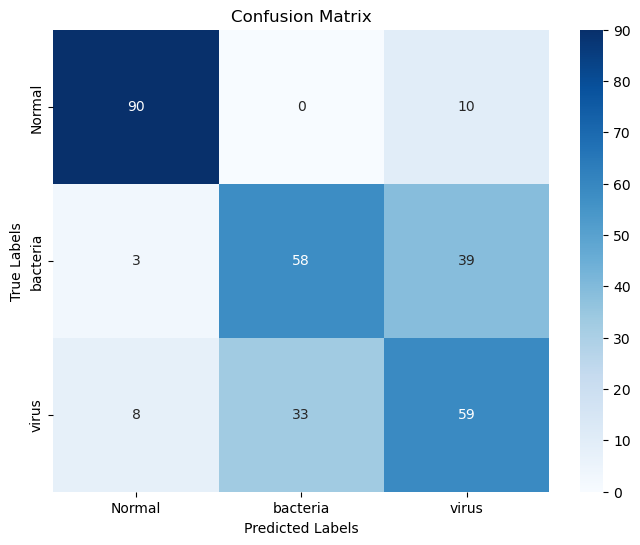

In [24]:
# Display confusion matrix using seaborn heatmap
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_set.class_indices, yticklabels=train_set.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Result from weights_filepath = "./saved_models/resnet_ckpt4_epoch_26_val_loss_0.596.weights.h5"

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true, y_pred, target_names=val_set.class_indices)
print(report)

              precision    recall  f1-score   support

      Normal       0.85      0.92      0.88       100
    bacteria       0.62      0.78      0.69       100
       virus       0.65      0.43      0.52       100

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.70       300
weighted avg       0.71      0.71      0.70       300



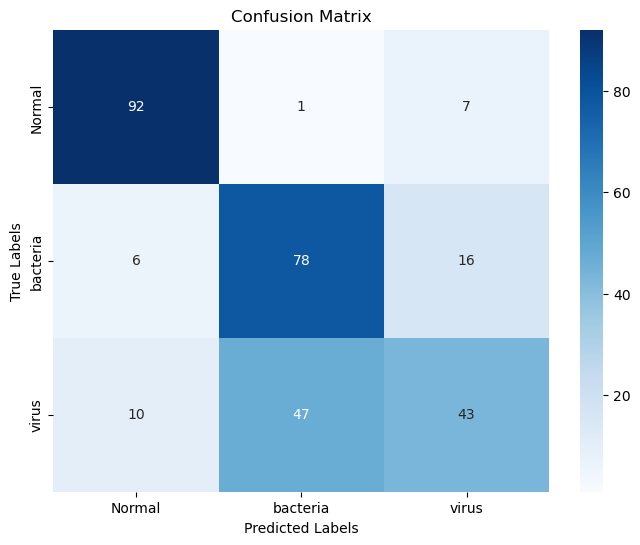

In [16]:
# Display confusion matrix using seaborn heatmap
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_set.class_indices, yticklabels=train_set.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Result from weights_filepath = "./saved_models/resnet_ckpt2_epoch_28_val_loss_0.62.weights.h5"

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true, y_pred, target_names=val_set.class_indices)
print(report)

              precision    recall  f1-score   support

      Normal       0.85      0.94      0.90       100
    bacteria       0.62      0.70      0.66       100
       virus       0.62      0.48      0.54       100

    accuracy                           0.71       300
   macro avg       0.70      0.71      0.70       300
weighted avg       0.70      0.71      0.70       300



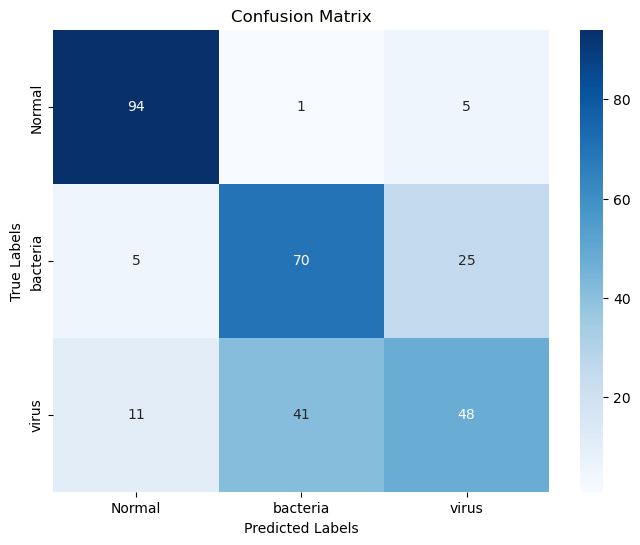

In [20]:
# Display confusion matrix using seaborn heatmap
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_set.class_indices, yticklabels=train_set.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Result from weights_filepath = "./saved_models/resnet_ckpt3_epoch_04_val_loss_0.608.weights.h5"

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true, y_pred, target_names=val_set.class_indices)
print(report)

              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89       100
    bacteria       0.63      0.72      0.67       100
       virus       0.60      0.50      0.54       100

    accuracy                           0.71       300
   macro avg       0.70      0.71      0.70       300
weighted avg       0.70      0.71      0.70       300



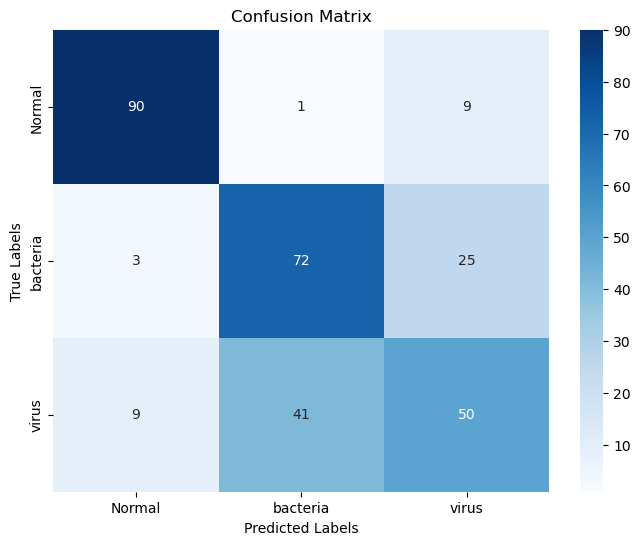

In [18]:
# Display confusion matrix using seaborn heatmap
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_set.class_indices, yticklabels=train_set.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()